# EEG Pipeline Tutorial

In this notebook, we will demonstrate how to use the newly implemented EEG pipeline of CMP3, using the "VEPCON" dataset, available at https://openneuro.org/datasets/ds003505/versions/1.1.1. 

It is important to note that CMP3 _does not_ include preprocessing of EEG data, so it is expected that you have your data ready to be analyzed. 

.. nbinfo:: **Important:** Note that the skull-surfaces provided with the dataset ("bem", see below) which are needed to create the head model are obtained from non-defaced MRIs. You will not be able to proceed with surfaces created from VEPCON dataset alone.

## Setup instructions

If you want to reproduce all the results of this notebook on your side, a conda ``environment.yml`` file can be downloaded at the following link: [EEG_tutorial_environment.yml](EEG_tutorial_environment.yml). The original ``.ipynb`` notebook file can be downloaded at the following link: [EEG_pipeline_tutorial.ipynb](https://github.com/connectomicslab/connectomemapper3/raw/master/docs/notebooks/EEG_pipeline_tutorial.ipynb).

Once you have downloaded the conda environment file, install the environment `py37cmp-eeg` as follows:
```bash
$ conda env create -f /path/to/downloaded/EEG_tutorial_environment.yml
```
This will install all the packages needed to run this notebook including jupyter lab.

You can then activate it, go to the directory where you downloaded the ``EEG_pipeline_tutorial.ipynb``, and launch jupyter lab as follows:

```bash
$ cd /directory/of/downloaded/EEG_pipeline_tutorial.ipynb
$ conda activate py37cmp-eeg
$ jupyter lab
```

You are ready to open and interact with the notebook!

In [ ]:
!pip install ../../.

## Loading the python packages used in the notebook

In [1]:
# General
import sys
import os
import argparse
import subprocess
import pdb
import pickle
import shutil
import json
from IPython.display import SVG, display
import warnings

# Dataset management
import datalad.api as dl

# Data/graph handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# BIDS import
from bids import BIDSLayout

# MNE imports
import mne
import mne_connectivity as mnec

# CMP3 imports
import cmp.project
from cmp.info import __version__, __copyright__
from cmtklib.util import print_error, print_blue, print_warning
from cmtklib.bids.io import (
    __nipype_directory__, __cartool_directory__,
    __eeglab_directory__, __cmp_directory__
)
# other
from EEG_tutorial_utils import (
    create_trans_files,
    fix_vepcon_derivatives_dataset_description_files
)

220709-17:01:15,509 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


## Loading the BIDS dataset

For demonstration, we are going to use the latest version of VEPCON dataset, available on [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.1.1)
that already contains outputs from Connectome Mapper v3.0.3 and Freesurfer 7.1.1. A full description of the dataset can be found in [Pascucci, Tourbier, et al. 2022].

In case you want to rerun the notebook, make sure to remove any `ds003505_demo` folder in the directory of the notebook. Otherwise, datalad install will complain.

[Pascucci, Tourbier, et al. 2022]: https://doi.org/10.1038/s41597-021-01116-1

In [2]:
%%time
# Download example dataset with datalad
bids_dir = os.path.join(".", "ds003505_demo")  # Adjust path to your BIDS dataset as needed
vepcon_data = dl.install(
    path=bids_dir,
    source="https://github.com/OpenNeuroDatasets/ds003505.git"
)

CPU times: user 9.95 ms, sys: 13.8 ms, total: 23.7 ms
Wall time: 58.6 ms


## Running the EEG pipeline

As of now, the EEG pipeline can only be run directly from the application programming interface (API) as demonstrated in this notebook. As soon as possible, we will integrate it into the graphical user interface (GUI) and the command line interface (CLI).

First, we need to configure the following user-defined arguments. Please modify them as needed.

In [3]:
# Adjust path to your BIDS dataset as needed
bids_dir = vepcon_data.path 

# Adjust path of the output directory as needed
output_dir = os.path.join(bids_dir, 'derivatives')

# Adjust the subject to be processed as needed
participant_label = 'sub-01'

# Adjust the name of the task to be considered
task_label = 'faces'

# Adjust path to the anatomical pipeline configuration file as needed
anat_pipeline_config = os.path.join(bids_dir, 'code', 'ConnectomeMapper-Docker', 'ref_anatomical_config.json')

# Adjust path to the MNE-based pipeline configuration file as needed
eeg_pipeline_config =  os.path.join('.', 'ref_mne_eeg_config.json')

The eeg pipeline config .json file contains information that CMP3 needs to correctly load EEG data and associated information like electrode positions, names of conditions, which parcellation to use, etc. as seen below:

In [4]:
%cat ref_mne_eeg_config.json

{
    "Global": {
        "process_type": "EEG",
        "subjects": [
            "sub-01"
        ],
        "subject": "sub-01",
        "version": "v3.1.0"
    },
    "eeg_preprocessing_stage": {
        "task_label": "faces",
        "eeg_ts_file.extension": "set",
        "eeg_ts_file.toolbox_derivatives_dir": "eeglab-v14.1.1",
        "eeg_ts_file.datatype": "eeg",
        "eeg_ts_file.suffix": "eeg",
        "eeg_ts_file.desc": "preproc",
        "eeg_ts_file.task": "faces",
        "events_file.datatype": "eeg",
        "events_file.suffix": "events",
        "events_file.extension": "tsv",
        "events_file.task": "faces",
        "electrodes_file_fmt": "Cartool",
        "cartool_electrodes_file.toolbox_derivatives_dir": "cartool-v3.80",
        "cartool_electrodes_file.datatype": "eeg",
        "cartool_electrodes_file.suffix": "eeg",
        "cartool_electrodes_file.extension": "xyz",
        "t_min": -0.2,
        "t_max": 0.5
    },
    "eeg_source_imaging_stage": {
 

.. nbinfo:: **Note:** If you would like to run another subject (all available subjects except subjects 5 and 15 can be run), you will need to modify the config files (replacing `sub-<label>` accordingly).

Then, we need to tell datalad to download the actual content of the structural MRI and EEG files that will be input to the pipelines.

In [5]:
%%time
# Raw MRI
vepcon_data.get(f'{participant_label}/anat/')

CPU times: user 7.09 ms, sys: 9.96 ms, total: 17 ms
Wall time: 135 ms


[{'action': 'get',
  'path': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat',
  'type': 'directory',
  'refds': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo',
  'status': 'notneeded',
  'message': ('nothing to get from %s',
   '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat')}]

In [6]:
%%time
# CMP3 and Freesurfer derivatives
vepcon_data.get(f'derivatives/cmp-v3.0.3/{participant_label}/anat/')
vepcon_data.get(f'derivatives/freesurfer-7.1.1/{participant_label}/')

CPU times: user 7.82 ms, sys: 10.2 ms, total: 18.1 ms
Wall time: 165 ms


[{'action': 'get',
  'path': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/freesurfer-7.1.1/sub-01',
  'type': 'directory',
  'refds': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo',
  'status': 'notneeded',
  'message': ('nothing to get from %s',
   '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/freesurfer-7.1.1/sub-01')}]

In [7]:
%%time
# Electrode position
vepcon_data.get(f'derivatives/{__cartool_directory__}/{participant_label}/' +
                f'eeg/{participant_label}_eeg.xyz')
# Preprocessed EEG in EEGLab .fdt/.set format
vepcon_data.get(f'derivatives/{__eeglab_directory__}/{participant_label}/eeg/' +
                f'{participant_label}_task-faces_desc-preproc_eeg.fdt')
vepcon_data.get(f'derivatives/{__eeglab_directory__}/{participant_label}/eeg/' +
                f'{participant_label}_task-faces_desc-preproc_eeg.set')

CPU times: user 11.1 ms, sys: 14.5 ms, total: 25.6 ms
Wall time: 223 ms


[{'action': 'get',
  'path': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/eeglab-v14.1.1/sub-01/eeg/sub-01_task-faces_desc-preproc_eeg.set',
  'type': 'file',
  'refds': '/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo',
  'status': 'notneeded',
  'message': 'already present'}]

In the latest version of VEPCON (``v1.1.1``) that we use in this tutorial, we notice that `dataset_description.json` files in the `derivatives/cartool-v3.80` and `derivatives/eeglab-v14.1.1` are invalid and will create an error if these directories are added to the BIDSLayout representation of the VEPCON dataset. We need to fix them by running the following helper function provided along this tutorial:

In [8]:
fix_vepcon_derivatives_dataset_description_files(os.path.abspath(bids_dir))

Replace /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cartool-v3.80/dataset_description.json
Replace /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/eeglab-v14.1.1/dataset_description.json


We can then configure a new CMP3 project.

In [9]:
# initialize project
project = cmp.project.ProjectInfo()
project.base_directory = os.path.abspath(bids_dir)
project.output_directory = os.path.abspath(output_dir)
project.subjects = ["{}".format(participant_label)]
project.subject = "{}".format(participant_label)

# VEPCON dataset does not have a subject/sessions structure
project.subject_sessions = [""]
project.subject_session = ""

# Set the path to the anatomical pipeline configuration file
project.anat_config_file = os.path.abspath(anat_pipeline_config)

As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us with the task of interacting with the files of the dataset.

In [10]:
# Represent the BIDS dataset as a PyBIDS BIDSLayout
bids_layout = BIDSLayout(project.base_directory)

Once set, we can run the anatomical pipeline, in order to obtain, among other things, Freesurfer derivatives necessary for the MNE pipeline.

Freesurfer and CMP3 derivatives are indeed provided with the VEPCON dataset, so we do not need to run it, but if run on a fresh dataset

In [11]:
%%time
# Do not run again the anatomical pipeline
# You will have to set it to True on a fresh dataset
run = False

# Initialize the anatomical pipeline reading the configuration file
anat_pipeline = cmp.project.init_anat_project(project, False)

if anat_pipeline is not None:
    # Check if inputs to anatomical pipeline are valid
    anat_valid_inputs = anat_pipeline.check_input(bids_layout, gui=False)
    if anat_valid_inputs:
        if run:
            print(">> Process anatomical pipeline")
            anat_pipeline.process()
    else:
        print_error("  .. ERROR: Invalid inputs")
        exit_code = 1

# Check if outputs to anatomical pipeline are valid
if run:
    anat_valid_outputs, msg = anat_pipeline.check_output()
else:
    anat_valid_outputs = True

# Set the freesurfer subjects directory and the subject id
project.freesurfer_subjects_dir = anat_pipeline.stages['Segmentation'].config.freesurfer_subjects_dir
project.freesurfer_subject_id = anat_pipeline.stages['Segmentation'].config.freesurfer_subject_id

  .. LOAD: Load anatomical config file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/code/ConnectomeMapper-Docker/ref_anatomical_config.json
  .. WARNING: CMP3 version used to generate the configuration files (v3.0.2)  and version of CMP3 used (v3.1.0) differ
**** Check Inputs  ****
> Looking in /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo for....
/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat/sub-01_T1w.nii.gz
... t1_file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat/sub-01_T1w.nii.gz
/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat/sub-01_T1w.json
... t1_json_file : /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/sub-01/anat/sub-01_T1w.json
Inputs check finished successfully. 
Only anatomical dat

In VEPCON, the electrode positions are provided in a file in the Cartool-derivatives folder, but CMP3 expects them in the EEGLAB-derivatives folder.

In [12]:
# To be Removed !!!
# Copy the file to the appropriate location
#cartool_file_location = os.path.join(
#    bids_dir, 'derivatives', __cartool_directory__,
#    participant_label,'eeg', participant_label + '_eeg.xyz'
#)
#eeglab_file_location = os.path.join(
#    bids_dir, 'derivatives', 'eeglab-v14.1.1',
#    participant_label, 'eeg', participant_label + '_eeg.xyz')

# if not os.path.exists(eeglab_file_location):
#    _ = shutil.copyfile(cartool_file_location, eeglab_file_location)

Since we are using non-defaced MRIs, which are not exactly the same as the ones provided on OpenNeuro, we need an additional transform that will be applied to the electrode positions.

In [13]:
# The following line creates the appropriate file with this transform in derivatives/cmp-v3.0.3:
create_trans_files(bids_dir, participant_label)

Overwriting existing file.


Finally, you can run the EEG pipeline.

In [14]:
%%time

from cmtklib import config

# IF on MacOSX, add /usr/sbin to the $PATH
# which contains sysctl
# Otherwise, Nipype raises an "/bin/sh: sysctl: command not found" error
# when trying to get the system memory
if "darwin" in sys.platform:
    os.environ["PATH"] = f'/usr/sbin/:{os.environ["PATH"]}'
# Note that "sysctl" can be located in a different place
# than "/usr/sbin".
# To know which path has to be added, you can run
# `locate sysctl`

# Set the path to the anatomical pipeline configurration file
eeg_pipeline_config = 'ref_mne_eeg_config.json'
project.eeg_config_file = os.path.abspath(eeg_pipeline_config)

if anat_valid_outputs:
    # Initialize the EEG pipeline reading the configuration file and
    # check input validity
    eeg_valid_inputs, eeg_pipeline = cmp.project.init_eeg_project(
        project, False
    )
    if eeg_pipeline is not None:
        eeg_pipeline.parcellation_scheme = anat_pipeline.parcellation_scheme
        eeg_pipeline.atlas_info = anat_pipeline.atlas_info
        eeg_pipeline.stages['EEGPreprocessing'].config.task_label = 'faces'

        if eeg_valid_inputs:
            print(">> Process EEG pipeline")
            eeg_pipeline.process()
        else:
            print("  .. ERROR: Invalid inputs")
            exit_code = 1
else:
    print_error(f'  .. ERROR: Invalid anatomical outputs for eeg pipeline')
    print_error(f'{msg}')
    exit_code = 1

**** Check Inputs ****
Base dir: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-01/eeg_pipeline
 .. DEBUG : Generated file name = sub-01_atlas-L2018_res-scale1_dseg.nii.gz
 .. DEBUG : Generated file name = sub-01_atlas-L2018_res-scale1_dseg.nii.gz
cmp-v3.0.3
220709-17:01:27,860 nipype.workflow INFO:
	 [Node] Setting-up "eeg_check_input" in "/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-01/eeg_pipeline/eeg_check_input".
220709-17:01:27,869 nipype.workflow INFO:
	 [Node] Executing "eeg_check_input" <nipype.interfaces.io.BIDSDataGrabber>
Load dataset_description for: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.0.3
Load dataset_description for: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/eeglab-v14.1.1
Load dataset_description for

        outer skin  (2562) -> inner skull (2562) ...
        outer skull (2562) -> outer skin  (2562) ...
        outer skull (2562) -> outer skull (2562) ...
        outer skull (2562) -> inner skull (2562) ...
        inner skull (2562) -> outer skin  (2562) ...
        inner skull (2562) -> outer skull (2562) ...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
IP approach required...
    Matrix coefficients (homog)...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix (homog)...
    Modify the original solution to incorporate IP approach...
        Combining...
        Scaling...
Solution ready.
BEM geometry computations complete.
220709-17:02:50,820 nipype.workflow INFO:
	 [Node] Finished "mne_createbem", elapsed time 63.377566s.
220709-17:02:51,340 nipype.workflow INFO:
	 [Job 1] Completed (eeg_pipeline.eeg_source_imaging_stage.mne_createbem).
220709-17:02:51,346 nipype.workflow INFO:
	 [MultiProc]

220709-17:13:16,364 nipype.workflow INFO:
	 [Node] Setting-up "eeg_pipeline.eeg_source_imaging_stage.mne_createfwd" in "/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-01/eeg_pipeline/eeg_source_imaging_stage/mne_createfwd".
220709-17:13:16,370 nipype.workflow INFO:
	 [Node] Executing "mne_createfwd" <cmtklib.interfaces.mne.CreateFwd>
Reading /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-01/eeg_pipeline/eeg_preprocessing_stage/eeglab2fif/epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128)  idle
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Source space          

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


220709-17:13:18,262 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 0/1.
                     Currently running:
                       * eeg_pipeline.eeg_source_imaging_stage.mne_createfwd


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.0s finished


    Skipping interior check for 1721 sources that fit inside a sphere of radius   53.7 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished



Setting up for EEG...
Computing EEG at 8196 source locations (free orientations)...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished



Finished.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written
220709-17:13:30,321 nipype.workflow INFO:
	 [Node] Finished "mne_createfwd", elapsed time 13.943436s.
220709-17:13:32,276 nipype.workflow INFO:
	 [Job 5] Completed (eeg_pipeline.eeg_source_imaging_stage.mne_createfwd).
220709-17:13:32,282 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
220709-17:13:32,370 nipype.workflow INFO:
	 [Node] Setting-up "eeg_pipeline.eeg_source_imaging_stage.mne_invsol" in "/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/nipype-1.7.0/sub-01/eeg_pipeline/eeg_source_imaging_stage/mne_invsol".
220709-17:13:32,379 nipype.workflow INFO:
	 [Node] Executing "mne_invsol" <cmtklib.interfaces.mne.MNEInverseSolutionROI>
Reading /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/n

combining the current components...
Processing epoch : 59 / 588
combining the current components...
Processing epoch : 60 / 588
combining the current components...
Processing epoch : 61 / 588
combining the current components...
Processing epoch : 62 / 588
combining the current components...
Processing epoch : 63 / 588
combining the current components...
Processing epoch : 64 / 588
combining the current components...
Processing epoch : 65 / 588
combining the current components...
Processing epoch : 66 / 588
combining the current components...
Processing epoch : 67 / 588
combining the current components...
Processing epoch : 68 / 588
combining the current components...
Processing epoch : 69 / 588
combining the current components...
Processing epoch : 70 / 588
combining the current components...
Processing epoch : 71 / 588
combining the current components...
Processing epoch : 72 / 588
combining the current components...
Processing epoch : 73 / 588
combining the current components...
Proc

combining the current components...
Processing epoch : 186 / 588
combining the current components...
Processing epoch : 187 / 588
combining the current components...
Processing epoch : 188 / 588
combining the current components...
Processing epoch : 189 / 588
combining the current components...
Processing epoch : 190 / 588
combining the current components...
Processing epoch : 191 / 588
combining the current components...
Processing epoch : 192 / 588
combining the current components...
Processing epoch : 193 / 588
combining the current components...
Processing epoch : 194 / 588
combining the current components...
Processing epoch : 195 / 588
combining the current components...
Processing epoch : 196 / 588
combining the current components...
Processing epoch : 197 / 588
combining the current components...
Processing epoch : 198 / 588
combining the current components...
Processing epoch : 199 / 588
combining the current components...
Processing epoch : 200 / 588
combining the current com

Processing epoch : 312 / 588
combining the current components...
Processing epoch : 313 / 588
combining the current components...
Processing epoch : 314 / 588
combining the current components...
Processing epoch : 315 / 588
combining the current components...
Processing epoch : 316 / 588
combining the current components...
Processing epoch : 317 / 588
combining the current components...
Processing epoch : 318 / 588
combining the current components...
Processing epoch : 319 / 588
combining the current components...
Processing epoch : 320 / 588
combining the current components...
Processing epoch : 321 / 588
combining the current components...
Processing epoch : 322 / 588
combining the current components...
Processing epoch : 323 / 588
combining the current components...
Processing epoch : 324 / 588
combining the current components...
Processing epoch : 325 / 588
combining the current components...
Processing epoch : 326 / 588
combining the current components...
Processing epoch : 327 / 

combining the current components...
Processing epoch : 439 / 588
combining the current components...
Processing epoch : 440 / 588
combining the current components...
Processing epoch : 441 / 588
combining the current components...
Processing epoch : 442 / 588
combining the current components...
Processing epoch : 443 / 588
combining the current components...
Processing epoch : 444 / 588
combining the current components...
Processing epoch : 445 / 588
combining the current components...
Processing epoch : 446 / 588
combining the current components...
Processing epoch : 447 / 588
combining the current components...
Processing epoch : 448 / 588
combining the current components...
Processing epoch : 449 / 588
combining the current components...
Processing epoch : 450 / 588
combining the current components...
Processing epoch : 451 / 588
combining the current components...
Processing epoch : 452 / 588
combining the current components...
Processing epoch : 453 / 588
combining the current com

Processing epoch : 565 / 588
combining the current components...
Processing epoch : 566 / 588
combining the current components...
Processing epoch : 567 / 588
combining the current components...
Processing epoch : 568 / 588
combining the current components...
Processing epoch : 569 / 588
combining the current components...
Processing epoch : 570 / 588
combining the current components...
Processing epoch : 571 / 588
combining the current components...
Processing epoch : 572 / 588
combining the current components...
Processing epoch : 573 / 588
combining the current components...
Processing epoch : 574 / 588
combining the current components...
Processing epoch : 575 / 588
combining the current components...
Processing epoch : 576 / 588
combining the current components...
Processing epoch : 577 / 588
combining the current components...
Processing epoch : 578 / 588
combining the current components...
Processing epoch : 579 / 588
combining the current components...
Processing epoch : 580 / 

Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting

Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting

Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting

Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting time courses for 70 labels (mode: pca_flip)
Extracting

220709-17:17:16,745 nipype.interface INFO:
	 sub: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.1.0/sub-01/eeg/conndata-network_connectivity.graphml -> /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.1.0/sub-01/eeg/sub-01_task-faces_atlas-L2018_res-scale1_conndata-network_connectivity.graphml
220709-17:17:16,749 nipype.workflow INFO:
	 [Node] Finished "eeg_datasinker", elapsed time 0.037833s.
220709-17:17:18,568 nipype.workflow INFO:
	 [Job 8] Completed (eeg_pipeline.eeg_datasinker).
220709-17:17:18,576 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
220709-17:17:21,115 nipype.interface INFO:
	 **** Processing finished ****
CPU times: user 16.5 s, sys: 1.98 s, total: 18.4 s
Wall time: 15min 58s


/Applications/miniconda3/envs/py37cmp-eeg/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:320: UserWarning: resource_tracker: There appear to be 6 leaked folder objects to clean up at shutdown
  (len(rtype_registry), rtype))
/Applications/miniconda3/envs/py37cmp-eeg/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:333: UserWarning: resource_tracker: /var/folders/vy/0bw_1jvj54n8lvcgvdrtqb0c0000gn/T/joblib_memmapping_folder_47551_379a43977f814190bfe6f03e92cfdae6_3fedd64ce92b49b9a6481229dccca45d: FileNotFoundError(2, 'No such file or directory')
  warnings.warn('resource_tracker: %s: %r' % (name, e))
/Applications/miniconda3/envs/py37cmp-eeg/lib/python3.7/site-packages/joblib/externals/loky/backend/resource_tracker.py:333: UserWarning: resource_tracker: /var/folders/vy/0bw_1jvj54n8lvcgvdrtqb0c0000gn/T/joblib_memmapping_folder_47551_379a43977f814190bfe6f03e92cfdae6_ae6b9e5318df4c718513b5ce780ef199: FileNotFoundError(2, 'No such fil

## A closer look at the EEG pipeline outputs

Let's have a closer look at the outputs that the EEG pipeline produces in the `derivatives/cmp-v3.1.0` derivatives directory.

First of all, connectomemapper works in such a way that the pipeline is first assembled and only afterwards, it is executed. During the assembly stage, input and output variables are connected and CMP3 produces a graph that visualizes this. 

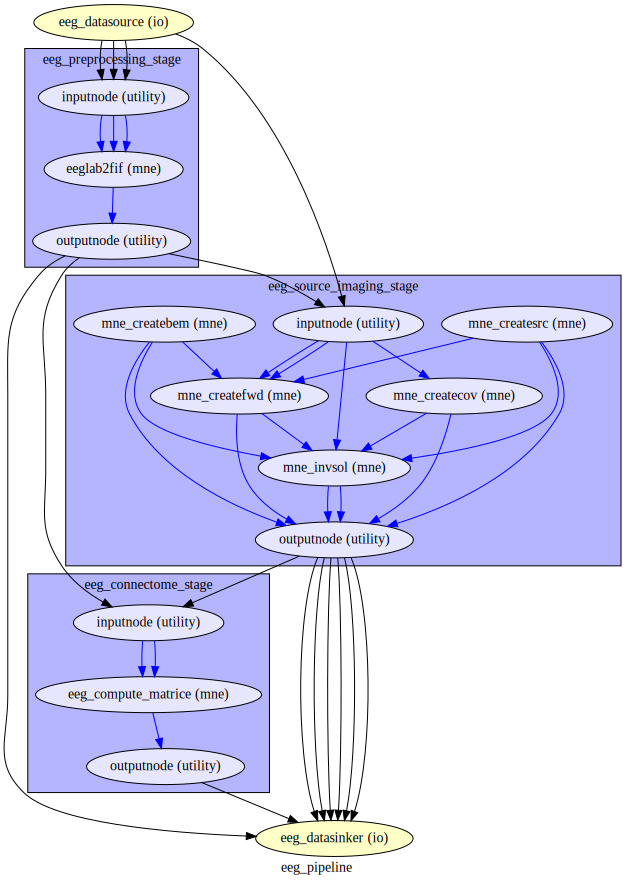

In [15]:
%matplotlib inline
path_to_svg = os.path.join(
    output_dir, __nipype_directory__, participant_label, 'eeg_pipeline','graph.svg'
)
display(SVG(filename=path_to_svg))

You can see three blue boxes that represent the different stages of the pipeline flow:

    * EEG preprocessing stage
    * EEG source imaging stage
    * EEG connectome stage

Each of the stages, again, has an input and and output node, as well as several nodes representing processing steps. Each processing step has its own "interface" which you can find in ``cmtklib/interfaces`` ("mne" in parentheses indicates that they are defined in the file mne.py).

`eeg_datasource` is the input BIDSDataGrabber node and `eeg_datasinker` is the output DataSinker node. `datasource` takes care of querying and injecting the input files in the different stages of the EEG pipeline. `eeg_sinker` is taking care of collecting, moving, and renaming all the files produced by the different stages to the `derivatives/cmp-v3.1.0` directory.

In the following, we will go over the interfaces and show what output they produce. 

### EEG preprocessing stage

The preprocessing stage consists of converting EEGLab `.set` EEG files to MNE Epochs in `.fif` format, the format used in the rest of the pipeline by calling, if necessary the following interface: 

- `EEGLAB2fif`: Read EEGLab data and converts them to MNE format (.fif file extension).

The information given by the config file regarding this stage is as follows: 

```json
[...]
    "eeg_preprocessing_stage": {
        "task_label": "faces",
        "eeg_ts_file.extension": "set",
        "eeg_ts_file.toolbox_derivatives_dir": "eeglab-v14.1.1",
        "eeg_ts_file.datatype": "eeg",
        "eeg_ts_file.suffix": "eeg",
        "eeg_ts_file.desc": "preproc",
        "eeg_ts_file.task": "faces",
        "events_file.datatype": "eeg",
        "events_file.suffix": "events",
        "events_file.extension": "tsv",
        "events_file.task": "faces",
        "electrodes_file_fmt": "Cartool",
        "cartool_electrodes_file.toolbox_derivatives_dir": "cartool-v3.80",
        "cartool_electrodes_file.datatype": "eeg",
        "cartool_electrodes_file.suffix": "eeg",
        "cartool_electrodes_file.extension": "xyz",
        "t_min": -0.2,
        "t_max": 0.5
    },
[...]
```

#### EEGLAB2fif

If your data are not already in MNE format (`.fif` file extension), they have to be read and re-saved. The eeglab2fif interface does this for EEGLAB-format data (`.set` file extension).

The interface produces a file named `sub-01_epo.fif` in the `derivatives/cmp-v3.0.3` folder.

Critically, the saved epochs contain a montage, i.e. the sensor locations which have to be supplied in a file names `sub-01.xyz` inside the subject's EEGLAB derivatives folder (`derivatives/eeglab-v14.1.1/sub-01/eeg/sub-01.xyz`). *Not sure it still applied :)*

In [16]:
# Let's have a look at the EEG data
with warnings.catch_warnings(): # suppress some irrelevant warnings coming from mne.read_epochs_eeglab()
    warnings.simplefilter("ignore")
    epochs_eeglab = mne.read_epochs_eeglab(
        os.path.join(output_dir, __eeglab_directory__,
                     participant_label, 'eeg',
                     participant_label + f'_task-{task_label}_desc-preproc_eeg.set')
    ) # sub-01_FACES_250HZ_prepd.set

# eeglab2fif removes a baseline and crops the epochs according to parameters start_t and end_t in config file
start_t = -0.2
end_t = 0.6
epochs_eeglab.apply_baseline((start_t, 0))
epochs_eeglab.crop(tmin=start_t, tmax=end_t)
evoked_eeglab = epochs_eeglab.average().pick('eeg')

# compare to what eeglab2fif saved
epochs_mne = mne.read_epochs(
    os.path.join(output_dir, __cmp_directory__,
                 participant_label, 'eeg',
                 participant_label + f'_task-{task_label}_epo.fif'))
evoked_mne = epochs_mne.average().pick('eeg')

Extracting parameters from /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/eeglab-v14.1.1/sub-01/eeg/sub-01_task-faces_desc-preproc_eeg.set...
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)
Reading /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.1.0/sub-01/eeg/sub-01_task-faces_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128)  idle
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


<Figure size 432x288 with 0 Axes>

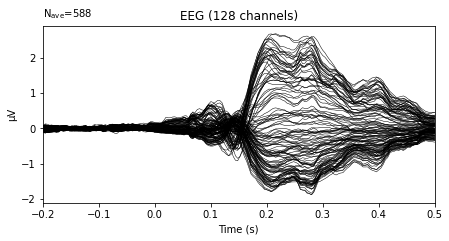

<Figure size 1080x720 with 0 Axes>

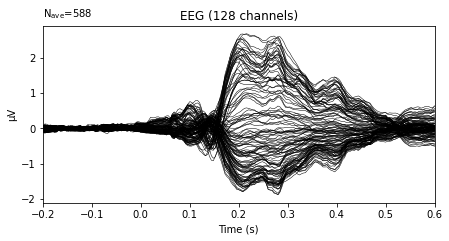

In [17]:
# plot and convince yourself it's the same
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_ = evoked_mne.plot(time_unit='s')

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10)

_ = evoked_eeglab.plot(time_unit='s')

### EEG source imaging stage

This stage takes your data in fif format from the "Preprocessing Stage", the parcellation, and the previously generated electrode transform file as inputs. With the aim to compute inverse solutions and extract ROI time courses with MNE, its workflow consists of five processing interfaces, : 

- `CreateBEM`: Create the boundary element method.
- `CreateSrc`: Create the dipole locations along the surface of the brain.
- `CreateFwd`: Create the forward solution (leadfield) from the BEM and the source space.
- `CreateCov`: Create the noise covariance matrix from the data.
- `MNEInverseSolutionROI`: Create the actual inverse operator and applies it, resulting in ROI-time courses.

The following possible EEG source imaging algorithms can be used for computing the inverse solutions: "sLORETA", "eLORETA", "MNE", and "dSPM". The configuration file of this tutorial is set to use "sLORETA".

The information given by the config file regarding this stage is as follows: 

```json
[...]
    "eeg_source_imaging_stage": {
        "esi_tool": "MNE",
        "mne_apply_electrode_transform": true,
        "mne_electrode_transform_file.toolbox_derivatives_dir": "cmp-v3.1.0",
        "mne_electrode_transform_file.datatype": "eeg",
        "mne_electrode_transform_file.suffix": "trans",
        "mne_electrode_transform_file.extension": "fif",
        "parcellation_scheme": "Lausanne2018",
        "lausanne2018_parcellation_res": "scale1",
        "mne_esi_method": "sLORETA",
        "mne_esi_method_snr": 3.0
    },
[...]
```

#### CreateBEM

The BEM (boundary element model) is the head model we use, in our case, it is based on the individual's structural MRI and, again, related freesurfer derivatives. Its creation consists of two steps:

1. The necessary surfaces (brain, inner skull, outer skull, and outer skin) are extracted using ``mne.bem.make_watershed_bem()``. The surfaces are saved in the subject's freesurfer-directory in a new folder `bem/` watershed.

2. The model itself is created using ``mne.make_bem_model()`` and ``mne.make_bem_solution()``. In this step, the surfaces and the tissue conductivities between the surfaces are used. 

In [18]:
# Let's visualize the BEM surfaces and source space
src = mne.read_source_spaces(
    os.path.join(
        output_dir,__cmp_directory__,
        participant_label, 'eeg', participant_label + f'_task-{task_label}_src.fif'))
# plot will appear in separate window
%matplotlib qt 
# lines are the surfaces, pink dots are the sources (dipoles)
_=mne.viz.plot_bem(
    subject=participant_label,
    subjects_dir=project.freesurfer_subjects_dir,
    brain_surfaces='white',
    src=src,
    orientation='sagittal'
)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Using surface: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/freesurfer-7.1.1/sub-01/bem/inner_skull.surf
Using surface: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/freesurfer-7.1.1/sub-01/bem/outer_skull.surf
Using surface: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/freesurfer-7.1.1/sub-01/bem/outer_skin.surf


#### CreateSrc

MNE is able to create volume- and surface-based source spaces, but in our pipeline, we use surface-based only. 

In order to do this, MNE takes advantage of the Freesurfer-created outputs in the `derivatives/freesurfer-7.1.1` derivatives directory. 

#### CreateFwd

MNE first computes a forward solution that describes how electrical currents propagate from the sources created earlier (via createsrc) through the tissues of the head modelled by the BEM (created via createbem) to the electrodes. Thus, the electrode positions have to be known and be aligned to the head model. 

In [19]:
# Let's check the alignment between MRI and electrode positions.
trans = mne.read_trans(
    os.path.join(
        output_dir, __cmp_directory__,
        participant_label, 'eeg', participant_label + '_trans.fif'
    )
)
mne.viz.plot_alignment(
    epochs_mne.info,
    trans=trans,
    subject=participant_label,
    subjects_dir=project.freesurfer_subjects_dir,
    dig=False,
    surfaces=dict(head=0.95),
    coord_frame='mri')

Using pyvistaqt 3d backend.

Using outer_skin.surf for head surface.
Channel types::	eeg: 128


#### CreateCov

MNE uses an estimate of signal to noise ratio in its creation of the inverse solution. For that, it considers the pre-stimulus period of the EEG recordings.

    128 x 128 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
Computing rank from covariance with rank=None
    Using tolerance 1.2e-14 (2.2e-16 eps * 128 dim * 0.43  max singular value)
    Estimated rank (eeg): 127
    EEG: rank 127 computed from 128 data channels with 0 projectors


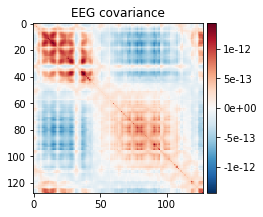

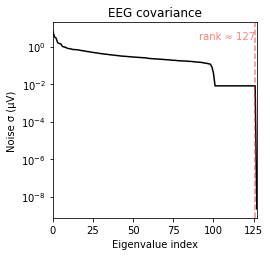

In [20]:
# Let's have a look at the noise covariance.
%matplotlib inline
noise_cov = mne.read_cov(
    os.path.join(
        output_dir, __cmp_directory__,
        participant_label, 'eeg', participant_label + f'_task-{task_label}_noisecov.fif'
    )
)
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, epochs_mne.info)

#### MNEInverseSolutionROI

Now, everything comes together to create the inverse operator, which is then applied to the EEG data to create source time courses. In the last step, the source time courses are converted to ROI-time courses according to the selected parcellation. 

The outputs that are necessary for this step to work were created in the previous processing steps, namely: 

- the EEG epochs in `.fif` format
- the electrode montage
- the head model
- the source point locations
- the forward operator
- the noise covariance

First, the inverse operator is created using ``mne.minimum_norm.make_inverse_operator()``.
We use the options `loose=1`, `depth=None`, and `fixed=False` to obtain full 3-dimensional dipoles whose orientation is not fixed or constrained to be (somewhat) orthogonal to surface; and we are not applying any depth weighting. The solution is finally written to a file `sub-01_task-faces_inv.fif` in the same directory as the other outputs (`derivatives/cmp-v3.1.0/sub-01/eeg`). 

In a subsequent step in the same interface, this inverse operator is then applied to the epochs (not the evoked time course averaged over trials) using mne.minimum_norm.apply_inverse_epochs. 

The final step performed by this interface and by the EEG pipeline is to use mne.extract_label_time_course to create ROI-time courses according to ``mne.read_labels_from_annot()``. As given in the config file, we use "lausanne2008" scale 1, which is the Desikan-atlas. The time courses and the ROI-names are stored in ``sub-01_task-faces_atlas-L2018_res-scale1_timeseries.pickle`` in pickle format.

Let's have a look at the time courses.

In [21]:
# Load the generated ROI time series file
roi_ts_fname = participant_label + f'_task-{task_label}_atlas-L2018_res-scale1_timeseries.pickle'
roi_ts_file = os.path.join(
    output_dir, __cmp_directory__,
    participant_label, 'eeg', roi_ts_fname
)
with open(roi_ts_file, 'rb') as f:
    rtc_epo = pickle.load(f)
    # For some reason, MNE writes label time courses as lists. convert to numpy array
    rtc_epo['data'] = np.array(rtc_epo['data'])

In [22]:
# Sort labels to make the time courses look nicer
N = len(rtc_epo['labels']) - 2  # two "unknown" regions - do not plot
sorting = list(np.arange(0, N, 2)) + list(np.arange(1, N, 2))  # left and right always alternating
# List of ROI names
labels_list_left = [i.name for i in rtc_epo['labels'][0::2] if i.name != 'unknown -lh']
labels_list_right = [i.name for i in rtc_epo['labels'][1::2] if i.name != 'unknown -rh']
labels_list = labels_list_left + labels_list_right

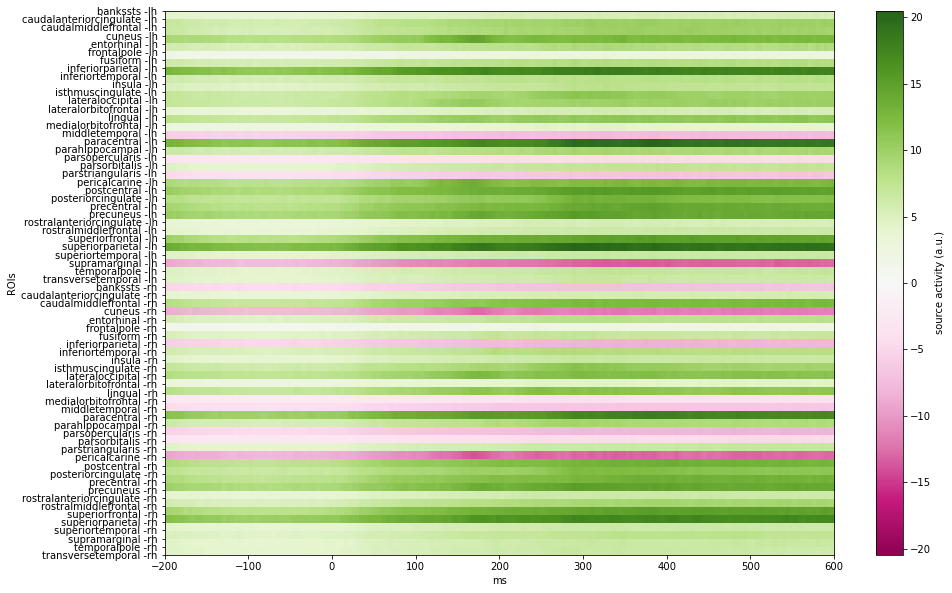

In [23]:
# Plot
%matplotlib inline
to_plot = np.mean(rtc_epo['data'][:, :-2, :], axis=0)
vminmax = np.max(abs(to_plot))
plt.rcParams['figure.figsize'] = (15, 10)
plt.imshow(
    to_plot[sorting, :],
    aspect='auto',
    extent=[-200, 600, 0, 67],
    interpolation='None',
    vmin=-vminmax,
    vmax=vminmax,
    cmap='PiYG'
);
plt.xlabel('ms')
plt.ylabel('ROIs')
cbar = plt.colorbar()
cbar.set_label('source activity (a.u.)')
locs = np.arange(0, N)
_ = plt.yticks(locs, labels_list[-1::-1] )  

We can see that some of the time courses are "flipped" (have the opposite sign of the others). We will not address this problem here, but this is because of the step where dipole time courses are summarized for each brain region, using PCA. The direction of the resulting vector is not uniquely defined.

This leads us to the last stage of the pipeline, the "Connectome Stage".

### EEG connectome stage

This stage aims to map the connectome from the extracted ROI time series and consists of one processing step: 

- `MNESpectralConnectivity`: Compute frequency- and time-frequency-domain connectivity measures and save the connectom files in different format.

The information given by the config file regarding this stage is as follows: 

```json
[...]
    "eeg_connectome_stage": {
        "connectivity_metrics": [
            "coh",
            "cohy",
            "imcoh",
            "plv",
            "ciplv",
            "ppc",
            "pli",
            "wpli",
            "wpli2_debiased"
        ],
        "output_types": [
            "tsv"
            "gPickle",
            "mat",
            "graphml"
        ]
    },
[...]
```

#### MNESpectralConnectivity

CMP3 uses [MNE-Connectivity](https://mne.tools/mne-connectivity) to compute the functional connectivity matrices. Results can be saved in the same formats (`['tsv', 'gPickle', 'mat', 'graphml']`) as the diffusion MRI and resting-state fMRI pipelines.

Keep in mind that we only plot a single subject's connectivity here, so it is not surprising if you do not see exactly what you would expect.

We can load the matrices in network format, by reading the gpickle files using Networkx:

In [24]:
# Index the new CMP3 derivatives including the connectome files
# in the BIDSLayout representation
bids_layout.add_derivatives(os.path.join(project.base_directory, "derivatives", "cmp-v3.1.0"))

# Query the generated connectome gpickle file
bids_query = {
    "subject": participant_label.split('-')[-1],  # Keep the label only, e.g. "01"
    "datatype": 'eeg',
    "atlas": 'L2018',
    "res": 'scale1',
    "suffix": 'connectivity',
    "extension": 'gpickle',
    "return_type": 'filename'
}
cmat_file = bids_layout.get(**bids_query)[0]  # BIDSLayout always return a list

# Load wpli2_debiased connectivity matrix from the connectome gpickle file
weight = "wpli2_debiased"
print(f'Load {weight} connectivity matrix from {cmat_file}')
G = nx.read_gpickle(cmat_file)  
A_wpli2_debiased = nx.to_numpy_array(G, weight=weight)
A_wpli2_debiased

Load dataset_description for: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.1.0
Load wpli2_debiased connectivity matrix from /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.1.0/sub-01/eeg/sub-01_task-faces_atlas-L2018_res-scale1_conndata-network_connectivity.gpickle


array([[ 0.        ,  0.00300068, -0.00054407, ...,  0.00141492,
        -0.00075917, -0.00026943],
       [ 0.00300068,  0.        ,  0.00172582, ...,  0.00125406,
        -0.00034805, -0.00099333],
       [-0.00054407,  0.00172582,  0.        , ..., -0.0008333 ,
         0.00116659,  0.00129021],
       ...,
       [ 0.00141492,  0.00125406, -0.0008333 , ...,  0.        ,
        -0.00041457,  0.00171886],
       [-0.00075917, -0.00034805,  0.00116659, ..., -0.00041457,
         0.        ,  0.00133674],
       [-0.00026943, -0.00099333,  0.00129021, ...,  0.00171886,
         0.00133674,  0.        ]])

Then, we can load and order the name of the labels from the dictionary storing the ROI timeseries results, and visualize the connectivity matrix in a pretty circular layout with [MNE-Connectivity](https://mne.tools/mne-connectivity) `viz.plot_connectivity_circle()` as follows:

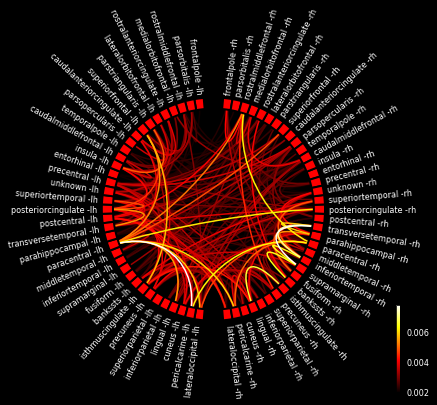

CPU times: user 8.77 s, sys: 47.8 ms, total: 8.82 s
Wall time: 8.41 s


(<Figure size 576x576 with 2 Axes>, <PolarAxesSubplot:>)

In [25]:
%%time
label_names = [label.name for label in rtc_epo['labels']]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(rtc_epo['labels'][idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = mnec.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
# plot will appear in separate window
%matplotlib inline 
mnec.viz.plot_connectivity_circle(A_wpli2_debiased, label_names, n_lines=300,
                         node_angles=node_angles, node_colors='r',
                         title='')

This concludes the tutorial 🧠!

We hope you enjoy it and any feedback or suggestions to improve it are very welcome! Just please open a [new issue](https://github.com/connectomicslab/connectomemapper3/issues/new) on GitHub and share your thoughts with us.